# Converting Codes into Amps and Volts using optimization

## Data Ingestion

### Get from AWS

In [9]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [10]:
import pandas as pd

telemetry_data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('jmts-current-comparison1')
)['Items']

pd.DataFrame.from_dict(telemetry_data)

,clockState,lastDeadman,throttleTooHigh,throttle,current,motorInitializing,timestamp,speed,rpm,test_id,voltage
0,0,00.00.00\n,0,0,1779,0,2023-05-26 22:00:00.306,0,0,jmts-current-comparison1,2426
1,0,00.00.00\n,0,0,1778,0,2023-05-26 22:00:00.406,0,0,jmts-current-comparison1,2427
2,0,00.00.00\n,0,0,1780,0,2023-05-26 22:00:00.505,0,0,jmts-current-comparison1,2423
3,0,00.00.00\n,0,0,1785,0,2023-05-26 22:00:00.605,0,0,jmts-current-comparison1,2427
4,0,00.00.00\n,0,0,1780,0,2023-05-26 22:00:00.705,0,0,jmts-current-comparison1,2426
...,...,...,...,...,...,...,...,...,...,...,...
418,0,00.00.00\n,0,0,1779,0,2023-05-26 22:01:57.673,0,0,jmts-current-comparison1,2423
419,0,00.00.00\n,0,0,1780,0,2023-05-26 22:01:57.676,0,0,jmts-current-comparison1,2427
420,0,00.00.00\n,0,0,1778,0,2023-05-26 22:02:00.197,0,0,jmts-current-comparison1,2423
421,0,00.00.00\n,0,0,1774,0,2023-05-26 22:02:00.202,0,0,jmts-current-comparison1,2426


### Get from DataLogger

In [11]:
from datetime import timedelta, datetime
import pandas as pd
datalogger = pd.read_csv("currentComparison1.csv")

# Adjust datalogger time to match aws data
timeOffset = timedelta(hours=1, seconds=-42)

dataloggerTimestamps = [(datetime.strptime(d, '%Y-%m-%d %H:%M:%S') + timeOffset) for d in datalogger['Date&Time']]
dataloggerCurrents = datalogger['CH5']

datalogger.head()

,No.,Date&Time,ms,CH4,CH5,CH6,Pulse1,Alarm1,AlarmLP,AlarmOut
0,1,2023-05-26 16:59:16,0,-0.0,-0.312,49.41,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
1,2,2023-05-26 16:59:16,50,-0.0,-0.304,49.41,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
2,3,2023-05-26 16:59:16,100,-0.0,-0.312,49.41,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
3,4,2023-05-26 16:59:16,150,-0.0,-0.312,49.41,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL
4,5,2023-05-26 16:59:16,200,-0.0,-0.312,49.41,0,LLLLLLLLLL,LLLLLLLLLLLLLLLL,LLLLLLLLL


### Processing Data

In [12]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime, timedelta

def codeToVoltage(x):
    return 0.02048 * x + -0.53823

def codeToAmps(x):
    return 0.01082 * x + -20.17682

processed: List[TelemetryDataPoint] = []

for point in telemetry_data:
    processed.append(
        TelemetryDataPoint(
            timestamp=datetime.strptime(point['timestamp'], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours= 4),
            speed=float(point['speed']) / 1000, # m/h -> km/h
            voltage=codeToVoltage(int(point['voltage'])),
            current=codeToAmps(int(point['current'])),
            rpm=int(point['rpm']) * -1
        )
    )

currentCodes = [int(p['current']) for p in telemetry_data]
voltageCodes = [int(p['voltage']) for p in telemetry_data]

instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)

## Graphing Data

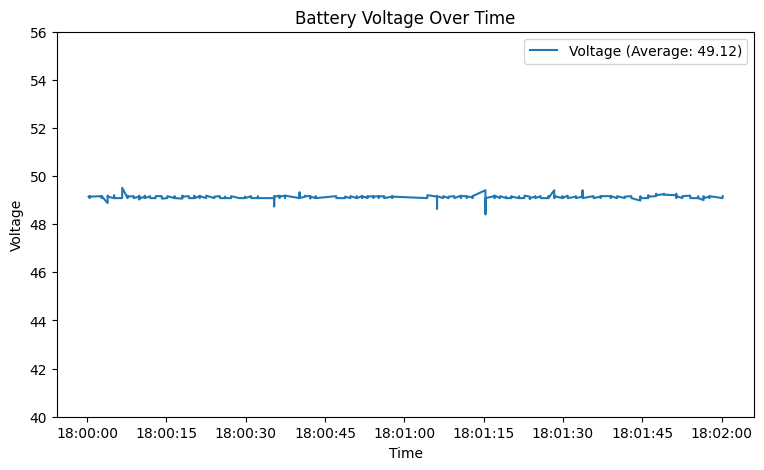

In [13]:
import matplotlib.pyplot as plt
timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
voltages = [point.voltage for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_ylim(40, 56)

ax.set_title("Battery Voltage Over Time")
ax.set_ylabel("Voltage")
ax.set_xlabel("Time")

ax.plot(timestamps, voltages, label="Voltage")
legend = ['Voltage (Average: %.2f)' %(sum(voltages) / len(voltages))]
ax.legend(legend)

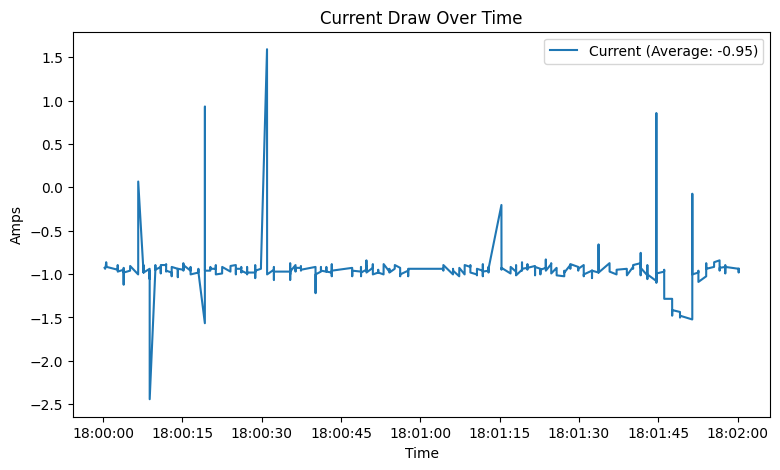

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("Current Draw Over Time")
ax.set_ylabel("Amps")
ax.set_xlabel("Time")

ax.plot(timestamps, currents)
legend = ['Current (Average: %.2f)' %(sum(currents) / len(currents))]
ax.legend(legend)

1740 3057
Current = 0.01082 * Codes + -20.17682


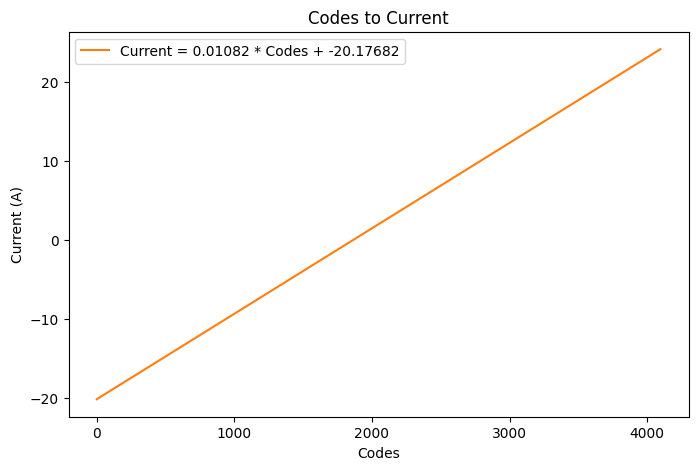

In [15]:
# SciPy's optimize functions require data to be sampled at same time
# This can be mitigated by interpolating datapoints using numpy
import numpy as np
from scipy.optimize import curve_fit

def objective(x, a, b):
    '''Objective for curve fitting'''
    return a * x + b

# Call numpy's interpolation function to get a current code for each timestamp that the datalogger records
interpolatedCurrentCodes = [np.interp(dt.timestamp(), [t.timestamp() for t in timestamps], currentCodes) for dt in dataloggerTimestamps]

interpolatedStart = 0
interpolatedEnd = 0

if len(timestamps) > 0 and len(dataloggerTimestamps) > 0:
    
    while interpolatedStart < len(dataloggerTimestamps) - 1 and dataloggerTimestamps[interpolatedStart] < timestamps[0]:
        interpolatedStart += 1
        
    while interpolatedEnd < len(dataloggerTimestamps) - 1 and dataloggerTimestamps[interpolatedEnd] < timestamps[-1]:
        interpolatedEnd += 1
    
print(interpolatedStart, interpolatedEnd)
    
if interpolatedStart != interpolatedEnd:
    # Call SciPy's curve_fit to get the best adjusted mx+b formula where x is codes and y is current in amps
    popt, _ = curve_fit(objective, interpolatedCurrentCodes[interpolatedStart:interpolatedEnd], dataloggerCurrents[interpolatedStart:interpolatedEnd])
    a, b = popt

    fig, ax = plt.subplots()
    fig.set_size_inches(8,5)

    ax.set_title("Codes to Current")
    ax.set_ylabel("Current (A)")
    ax.set_xlabel("Codes")

    x = np.linspace(0,4096,100)
    y = a*x + b
    ax.plot(x, y, color="tab:orange")

    legend = ["Current = %.5f * Codes + %.5f" % (a, b)]
    ax.legend(legend)
    print("Current = %.5f * Codes + %.5f" % (a, b))
else:
    print("No overlapping data to optimize")

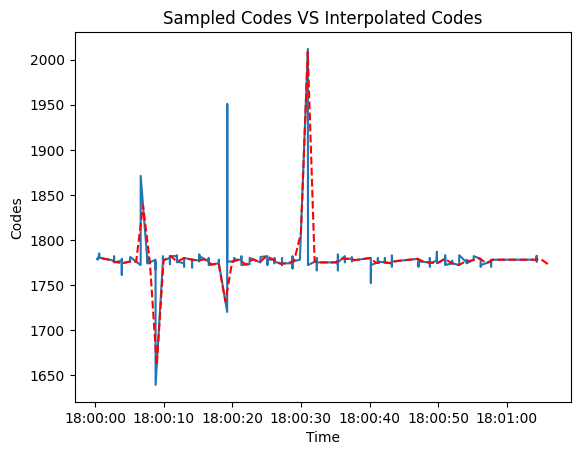

In [16]:
fig, ax = plt.subplots()

ax.set_title("Sampled Codes VS Interpolated Codes")
ax.set_xlabel("Time")
ax.set_ylabel("Codes")

realStart = 0
realEnd = 0

if len(timestamps) > 0 and len(dataloggerTimestamps) > 0:
    
    while realStart < len(timestamps) - 1 and timestamps[realStart] < dataloggerTimestamps[0]:
        realStart += 1
        
    while realEnd < len(timestamps) - 1 and timestamps[realEnd] < dataloggerTimestamps[-1]:
        realEnd += 1


ax.plot(timestamps[realStart:realEnd], currentCodes[realStart:realEnd], color="tab:blue")
ax.plot(dataloggerTimestamps[interpolatedStart:interpolatedEnd], interpolatedCurrentCodes[interpolatedStart:interpolatedEnd], '--r')